In [47]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

In [53]:
load_data = pd.read_csv('./data/Load_history.csv')
temp_data = pd.read_csv('./data/temperature_history.csv')

In [79]:
train_load_data = load_data.loc[~load_data['h7'].isna()]
test_load_data = load_data.loc[load_data['h7'].isna()]

# list of targets
hours = [f'h{i}' for i in range(1,24+1)]
# convert target to float64: remove comma first then convert
for target_col in hours: 
    train_load_data[f'{target_col}'] = train_load_data[f'{target_col}'].map(lambda x: x.replace(',', ''))
    train_load_data[f'{target_col}'] = train_load_data[f'{target_col}'].astype(np.float64)
print(type(train_load_data['h1'][0]))

# temp 
train_temp_data = temp_data.loc[~temp_data['h7'].isna()]
test_temp_data = temp_data.loc[temp_data['h7'].isna()]

c:\users\faroo\documents\kaggle_project\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\faroo\documents\kaggle_project\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'numpy.float64'>


# approach for grouping temp to load history

- do it by date first -> might not be feasable if dates are not unique
    - to try and fix this we can make some assumption based the station

In [103]:
date_cols_list = ['year', 'month', 'day']
train_load_data['datetime'] = pd.to_datetime(train_load_data[date_cols_list])
train_temp_data['datetime'] = pd.to_datetime(train_temp_data[date_cols_list])


train_load_data['weekday'] = train_load_data['datetime'].dt.dayofweek
train_load_data['week_of_year'] = train_load_data['datetime'].dt.weekofyear
train_load_data['day_of_year'] = train_load_data['datetime'].dt.dayofyear
train_load_data['is_month_start'] = (train_load_data['datetime'].dt.is_month_start).astype(int) 
train_load_data['is_month_end'] = (train_load_data['datetime'].dt.is_month_end).astype(int) 

train_temp_data['weekday'] = train_temp_data['datetime'].dt.dayofweek
train_temp_data['week_of_year'] = train_temp_data['datetime'].dt.weekofyear
train_temp_data['day_of_year'] = train_temp_data['datetime'].dt.dayofyear
train_temp_data['is_month_start'] = (train_temp_data['datetime'].dt.is_month_start).astype(int) 
train_temp_data['is_month_end'] = (train_temp_data['datetime'].dt.is_month_end).astype(int) 

In [83]:
train_temp_data['datetime'].value_counts().head()

2008-02-04    11
2006-04-17    11
2004-06-17    11
2005-08-08    11
2007-11-20    11
Name: datetime, dtype: int64

In [84]:
# rename hour cols for concatenation
hours = [f'h{hour}' for hour in range(1,24+1)]
load_hour_rename = [f'load_h{hour}' for hour in range(1,24+1)]
temp_hour_rename = [f'temp_h{hour}' for hour in range(1,24+1)]
load_columns_rename_dict = {}
for hour, rename in zip(hours, load_hour_rename): 
    load_columns_rename_dict[hour] = rename
    
temp_columns_rename_dict = {}
for hour, rename in zip(hours, temp_hour_rename): 
    temp_columns_rename_dict[hour] = rename
    
train_load_data = train_load_data.rename(columns=load_columns_rename_dict)
train_temp_data = train_temp_data.rename(columns=temp_columns_rename_dict)

In [85]:
train_load_data.head()

,zone_id,year,month,day,load_h1,load_h2,load_h3,load_h4,load_h5,load_h6,...,load_h16,load_h17,load_h18,load_h19,load_h20,load_h21,load_h22,load_h23,load_h24,datetime
0,1,2004,1,1,16853.0,16450.0,16517.0,16873.0,17064.0,17727.0,...,13138.0,14130.0,16809.0,18150.0,18235.0,17925.0,16904.0,16162.0,14750.0,2004-01-01
1,1,2004,1,2,14155.0,14038.0,14019.0,14489.0,14920.0,16072.0,...,15448.0,15839.0,17727.0,18895.0,18650.0,18443.0,17580.0,16467.0,15258.0,2004-01-02
2,1,2004,1,3,14439.0,14272.0,14109.0,14081.0,14775.0,15491.0,...,13414.0,13826.0,15825.0,16996.0,16394.0,15406.0,14278.0,13315.0,12424.0,2004-01-03
3,1,2004,1,4,11273.0,10415.0,9943.0,9859.0,9881.0,10248.0,...,13614.0,14162.0,16237.0,17430.0,17218.0,16633.0,15238.0,13580.0,11727.0,2004-01-04
4,1,2004,1,5,10750.0,10321.0,10107.0,10065.0,10419.0,12101.0,...,14350.0,15501.0,17307.0,18786.0,19089.0,19192.0,18416.0,17006.0,16018.0,2004-01-05


In [109]:
train_load_data['zone_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [86]:
train_temp_data.head()

,station_id,year,month,day,temp_h1,temp_h2,temp_h3,temp_h4,temp_h5,temp_h6,...,temp_h16,temp_h17,temp_h18,temp_h19,temp_h20,temp_h21,temp_h22,temp_h23,temp_h24,datetime
0,1,2004,1,1,46,46,45,41,39,35,...,55.0,52.0,46.0,40.0,40.0,39.0,38.0,40.0,41.0,2004-01-01
1,1,2004,1,2,43,44,46,46,47,47,...,56.0,57.0,53.0,50.0,47.0,46.0,45.0,45.0,45.0,2004-01-02
2,1,2004,1,3,45,46,46,44,43,46,...,68.0,68.0,65.0,64.0,63.0,62.0,63.0,63.0,62.0,2004-01-03
3,1,2004,1,4,63,62,62,62,60,60,...,72.0,71.0,68.0,67.0,67.0,65.0,64.0,65.0,64.0,2004-01-04
4,1,2004,1,5,64,63,65,64,64,64,...,66.0,66.0,66.0,63.0,54.0,52.0,49.0,47.0,47.0,2004-01-05


In [87]:
# cols_to_view = ['year', 'month', 'day', 'datetime', 'zone_id', 'station_id']

# # add temp hour data to train_laod_data based on same datetime
# load_row_index = 0
# temp_row_index = 0
# for load_row_index in train_loap_data.shape[0]:
#     for temp_row_index in train_temp_data.shape[0]:
#     if train_load_data.loc[load_row_index, 'datetime'] == train_temp_data.loc[temp_row_index, 'datetime']:
        
#         train_temp_data.loc[0, temp_hour_rename]
        

# train_temp_data['datetime'][0] == train_load_data['datetime'][0]

In [88]:
train_temp_data.shape[0]

18062

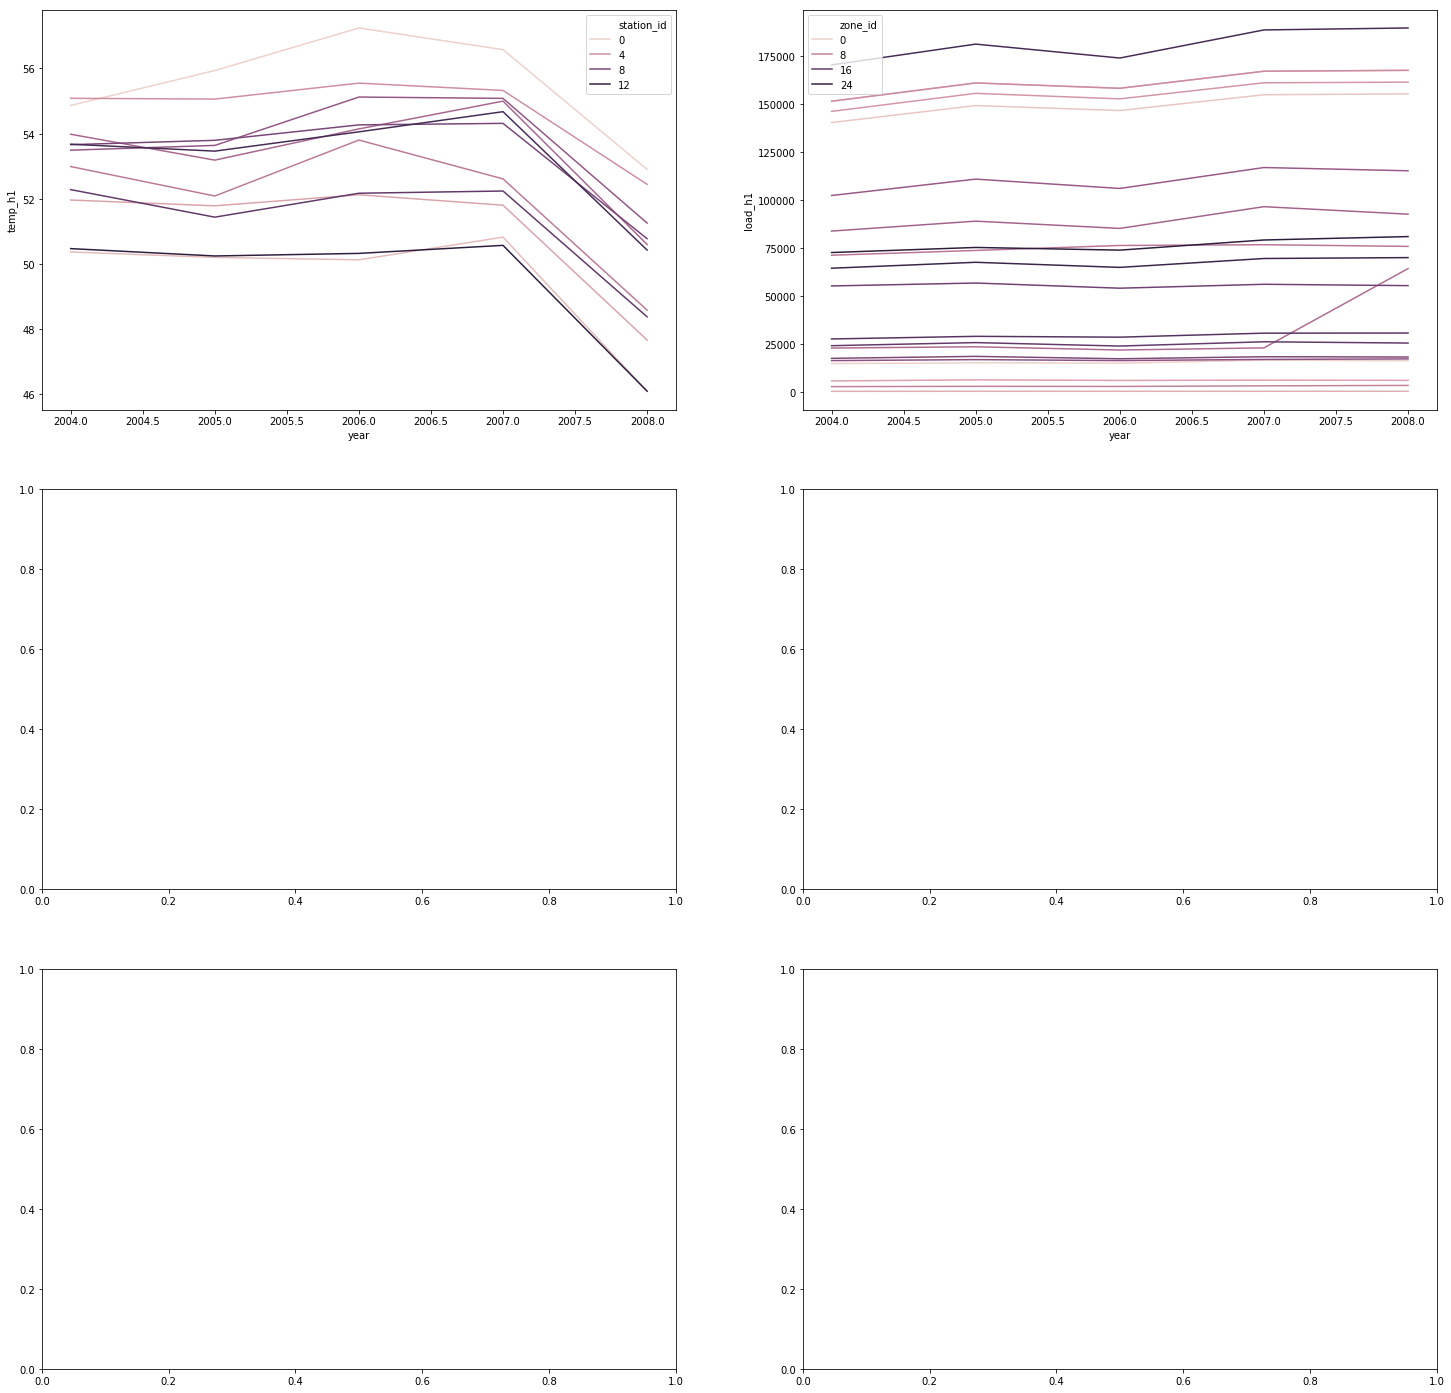

In [110]:
fig, axes = plt.subplots(3,2, figsize=(25,25))

sns.lineplot(x='year', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[0,0])
sns.lineplot(x='year', y='load_h1', hue="zone_id",  err_style=None, data=train_load_data, ax=axes[0,1])
